In [1]:
import numpy as np
from copy import deepcopy

from astropy.time import Time
from astropy.table import vstack
import astropy.io.ascii as asci
import astropy.constants as const

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

import matplotlib
import matplotlib.pyplot as plt
fs= 10
matplotlib.rcParams['font.size']=fs
ms = 6
matplotlib.rcParams['lines.markersize']=ms
from matplotlib import gridspec

In [2]:
z = 0.018
tmax = 59321  

D_pc = cosmo.luminosity_distance([z])[0].value * 1e+6 
D_10kpc = D_pc / (1e+4)
D_cm = D_pc * const.pc.cgs.value

In [3]:
def add_xray_pars(axs, doOLD = False):
    if doOLD:
        # XMM Newton & joint NoSTAR & xx
        sum_name = "./Xray_xmm_nu_pars.dat"
        tb0 = asci.read(sum_name)
        
        # NICER
        print ("Reading NICER spectral pars...")
        sum_name = "../nicer/tables/Xray_pars_ni_obsid.dat"
        tb1 = asci.read(sum_name)
        
        do_ni_fixNh = True
        if do_ni_fixNh:
            print ("Processing NICER table...")
            colnames = tb1.colnames
            for i in range(len(colnames)):
                colname = colnames[i]
                if len(colname) > 6:
                    if colname[-6:] == "_fixNh":
                        #print (colname)
                        if colname[:-6] in colnames:
                            #print ("remove", colname[:-6])
                            tb1.remove_column(colname[:-6])
                        #print ("raname", colname, "to", colname[:-6])
                        tb1.rename_column(colname, colname[:-6])
            tb1["nH"] = 9.97
            tb1["nH_left"] = 0
            tb1["nH_right"] = 0
            
        print ("Reading NICER spectral pars... (obsid)")
        sum_name = "../nicer/tables/Xray_pars_ni_obsid.dat"
        tb2 = asci.read(sum_name)
        
        if do_ni_fixNh:
            print ("Processing NICER table...(obsid)")
            colnames = tb2.colnames
            for i in range(len(colnames)):
                colname = colnames[i]
                if len(colname) > 6:
                    if colname[-6:] == "_fixNh":
                        #print (colname)
                        if colname[:-6] in colnames:
                            #print ("remove", colname[:-6])
                            tb2.remove_column(colname[:-6])
                        #print ("raname", colname, "to", colname[:-6])
                        tb2.rename_column(colname, colname[:-6])
            tb2["nH"] = 9.97
            tb2["nH_left"] = 0
            tb2["nH_right"] = 0
        ix2 = tb2["mjd"]>max(tb1["mjd"])
        tb2 = tb2[ix2]
                
        # XRT
        sum_name = "../xrt/tables/XRT_specpars.dat"
        tb3 = asci.read(sum_name)
        do_xrt_fixNh = True
        if do_xrt_fixNh:
            print ("Processing XRT table...")
            colnames = tb3.colnames
            for i in range(len(colnames)):
                colname = colnames[i]
                if len(colname) > 6:
                    if colname[-6:] == "_fixNh":
                        #print (colname)
                        if colname[:-6] in colnames:
                            #print ("remove", colname[:-6])
                            tb3.remove_column(colname[:-6])
                        #print ("raname", colname, "to", colname[:-6])
                        tb3.rename_column(colname, colname[:-6])
            tb3["nH"] = 9.97
            tb3["nH_left"] = 0
            tb3["nH_right"] = 0
        
        tb = vstack([tb0, tb1, tb2, tb3])
    
        #nH, nH_left, nH_right = tb["nH"].data, tb["nH_left"].data, tb["nH_right"].data
        Tin, Tin_left, Tin_right = tb["Tin"].data, tb["Tin_left"].data, tb["Tin_right"].data
        Rin, Rin_left, Rin_right = tb["Rin"].data, tb["Rin_left"].data, tb["Rin_right"].data
        Gamma, Gamma_left, Gamma_right = tb["Gamma"].data, tb["Gamma_left"].data, tb["Gamma_right"].data
        #fl, fl_left, fl_right = tb["fl"].data, tb["fl_left"].data, tb["fl_right"].data
        f_PL, f_PL_unc = tb["f_PL"].data, tb["f_PL_unc"].data
        
        x = tb["x"].data
        x_unc = tb["x_unc"].data
        inst = tb["inst"].data
        
        color_xrt = "k"
        zorder_xrt = 3
        ix_xrt = inst == "xrt"
        marker_xrt = "s"
        ms_xrt = 3
        elwidth_xrt = 0.9
        add_par(axs[2], ix_xrt, x, x_unc, Tin, Tin_left, Tin_right, color_xrt, zorder_xrt,
                marker_xrt, ms_xrt, elwidth_xrt, mylabel = "XRT")
        add_par(axs[3], ix_xrt, x, x_unc, Rin, Rin_left, Rin_right, color_xrt, zorder_xrt,
                marker_xrt, ms_xrt, elwidth_xrt)
        add_par(axs[4], ix_xrt, x, x_unc, Gamma, Gamma_left, Gamma_right, color_xrt, zorder_xrt,
                marker_xrt, ms_xrt, elwidth_xrt)
        add_par(axs[5], ix_xrt, x, x_unc, f_PL, f_PL_unc, f_PL_unc, color_xrt, zorder_xrt,
                marker_xrt, ms_xrt, elwidth_xrt)
        
        
        color_ni = "darkgoldenrod"
        zorder_ni = 2
        ix_ni = inst == "nicer"
        ms_ni = 2
        marker_ni = "o"
        
        add_par(axs[2], ix_ni, x, x_unc, Tin, Tin_left, Tin_right, color_ni, zorder_ni,
                marker_ni, ms_ni, mylabel = "$NICER$")
        add_par(axs[3], ix_ni, x, x_unc, Rin, Rin_left, Rin_right, color_ni, zorder_ni,
                marker_ni, ms_ni)
        add_par(axs[4], ix_ni, x, x_unc, Gamma, Gamma_left, Gamma_right, color_ni, zorder_ni,
                marker_ni, ms_ni)
        add_par(axs[5], ix_ni, x, x_unc, f_PL, f_PL_unc, f_PL_unc, color_ni, zorder_ni,
                marker_ni, ms_ni)
        
    # add NuSTAR+NICER joint observation fitting result
    te1 = (Time("2021-11-19").mjd-tmax)/(1+z)
    te2 = (Time("2022-01-11").mjd-tmax)/(1+z)
    color_nu = "blue"
    marker_nu = "D"
    ms_nu = 4
    
    Ts = np.array([164, 187]) * 1.60218e-12 / const.k_B.cgs.value
    Ts_unc_right = np.array([6, 19]) * 1.60218e-12 / const.k_B.cgs.value
    Ts_unc_left = np.array([9, 19]) * 1.60218e-12 / const.k_B.cgs.value
    lgTs = np.log10(Ts)
    lgTs_unc_right = Ts_unc_right /  Ts / np.log(10)
    lgTs_unc_left = Ts_unc_left /  Ts / np.log(10)
    axs[2-2].errorbar([te1, te2], lgTs, yerr = [lgTs_unc_left, lgTs_unc_right],
                    color = color_nu, fmt = marker_nu, markersize = ms_nu,
                    label = "$NICER+NuSTAR$", 
                    zorder = 20, markerfacecolor = "none")
    
    Rs = np.array([25.5, 31.7]) * 1e+9
    Rs_unc_right = np.array([4.4, 3.2]) * 1e+9
    Rs_unc_left = np.array([2.0, 3.2]) * 1e+9
    lgRs = np.log10(Rs)
    lgRs_unc_right = Rs_unc_right /  Rs / np.log(10)
    lgRs_unc_left = Rs_unc_left / Rs / np.log(10)
    axs[3-2].errorbar([te1, te2], lgRs, yerr = [lgRs_unc_left, lgRs_unc_right],
                    color = color_nu, fmt = marker_nu, markersize = ms_nu,
                    zorder = 20, markerfacecolor = "none")
    
    Gammas = np.array([2.29, 2.09])
    Gammas_unc_right = np.array([0.05, 0.21])
    Gammas_unc_left = np.array([0.05, 0.21])
    axs[4-2].errorbar([te1, te2], Gammas, yerr = [Gammas_unc_left, Gammas_unc_right],
                    color = color_nu, fmt = marker_nu, markersize = ms_nu,
                    zorder = 20, markerfacecolor = "none")
    
    fscs = np.array([0.35, 0.52])
    fscs_unc_right = np.array([0.02, 0.05])
    fscs_unc_left = np.array([0.03, 0.05])
    axs[5-2].errorbar([te1, te2], fscs, yerr = [fscs_unc_left, fscs_unc_right],
                    zorder = 20, markerfacecolor = "none", 
                    color = color_nu, fmt = marker_nu, markersize = ms_nu)
    
    
    # add XMM observations
    te1 = (Time("2021-08-04").mjd-tmax)/(1+z)
    te2 = (Time("2022-01-25").mjd-tmax)/(1+z)
    color_xmm = "darkcyan"
    marker_xmm = "h"
    ms_xmm = 5.5
    
    Ts = np.array([68, 125]) * 1.60218e-12 / const.k_B.cgs.value
    Ts_unc_right = np.array([1, 8]) * 1.60218e-12 / const.k_B.cgs.value
    Ts_unc_left = np.array([4, 8]) * 1.60218e-12 / const.k_B.cgs.value
    lgTs = np.log10(Ts)
    lgTs_unc_right = Ts_unc_right /  Ts / np.log(10)
    lgTs_unc_left = Ts_unc_left /  Ts / np.log(10)
    axs[2-2].errorbar([te1, te2], lgTs, yerr = [lgTs_unc_left, lgTs_unc_right],
                    color = color_xmm, fmt = marker_xmm, markersize = ms_xmm, label = "$XMM$-$Newton$", 
                    zorder = 20, markerfacecolor = "none")
    
    Rs = np.array([511, 39]) * 1e+9
    Rs_unc_right = np.array([144, 18]) * 1e+9
    Rs_unc_left = np.array([75, 6]) * 1e+9
    lgRs = np.log10(Rs)
    lgRs_unc_right = Rs_unc_right /  Rs / np.log(10)
    lgRs_unc_left = Rs_unc_left / Rs / np.log(10)
    axs[3-2].errorbar([te1, te2], lgRs, yerr = [lgRs_unc_left, lgRs_unc_right],
                    zorder = 20, markerfacecolor = "none", 
                    color = color_xmm, fmt = marker_xmm, markersize = ms_xmm)
    
    Gammas = np.array([4.57, 2.92])
    Gammas_unc_right = np.array([0., 0.15])
    Gammas_unc_left = np.array([0., 0.15])
    axs[4-2].errorbar([te1, te2], Gammas, yerr = [Gammas_unc_left, Gammas_unc_right],
                    zorder = 20, markerfacecolor = "none", 
                    color = color_xmm, fmt = marker_xmm, markersize = ms_xmm)
    axs[4-2].arrow(te1, Gammas[0], 0, 0.2, head_width=10, head_length = 0.2, 
             color = color_xmm)
    
    fscs = np.array([0.13, 0.16])
    fscs_unc_right = np.array([0.03, 0.03])
    fscs_unc_left = np.array([0.01, 0.03])
    axs[5-2].errorbar([te1, te2], fscs, yerr = [fscs_unc_left, fscs_unc_right],
                    zorder = 20, markerfacecolor = "none", 
                    color = color_xmm, fmt = marker_xmm, markersize = ms_xmm)
    
    # add SRG observations
    te1 = (Time("2021-08-17").mjd-tmax)/(1+z)
    te2 = (Time("2022-02-15").mjd-tmax)/(1+z)
    color_srg = "salmon"
    marker_srg = "p"
    ms_srg = 5
    
    Ts = np.array([89, 96]) * 1.60218e-12 / const.k_B.cgs.value
    Ts_unc_right = np.array([7, 32]) * 1.60218e-12 / const.k_B.cgs.value
    Ts_unc_left = np.array([13, 22]) * 1.60218e-12 / const.k_B.cgs.value
    lgTs = np.log10(Ts)
    lgTs_unc_right = Ts_unc_right /  Ts / np.log(10)
    lgTs_unc_left = Ts_unc_left /  Ts / np.log(10)
    axs[2-2].errorbar([te1, te2], lgTs, yerr = [lgTs_unc_left, lgTs_unc_right],
                    color = color_srg, fmt = marker_srg, markersize = ms_srg,
                    markerfacecolor = "none", label = "$SRG$", 
                    zorder = 20, elinewidth = 0.7)
    
    Rs = np.array([210, 73]) * 1e+9
    Rs_unc_right = np.array([179, 243]) * 1e+9
    Rs_unc_left = np.array([38, 21]) * 1e+9
    lgRs = np.log10(Rs)
    lgRs_unc_right = Rs_unc_right /  Rs / np.log(10)
    lgRs_unc_left = Rs_unc_left / Rs / np.log(10)
    axs[3-2].errorbar([te1, te2], lgRs, yerr = [lgRs_unc_left, lgRs_unc_right],
                    color = color_srg, fmt = marker_srg, markersize = ms_srg,
                    markerfacecolor = "none", 
                    zorder = 20, elinewidth = 0.7)
    
    
    Gammas = np.array([4.15, 2.92])
    Gammas_unc_right = np.array([0.82, 0.])
    Gammas_unc_left = np.array([0.73, 0.])
    axs[4-2].errorbar([te1], [Gammas[0]], yerr = [[Gammas_unc_left[0]], [Gammas_unc_right[0]]],
                    color = color_srg, fmt = marker_srg, markersize = ms_srg,
                    markerfacecolor = "none", 
                    zorder = 20, elinewidth = 0.7)
    axs[4-2].plot([te2], Gammas[1], 
                    color = color_srg, marker = marker_srg, markersize = ms_srg,
                    markerfacecolor = "none", 
                    zorder = 20,  alpha = 0.6)
    
    fscs = np.array([0.14, 0.21])
    fscs_unc_right = np.array([0.12, 0.06])
    fscs_unc_left = np.array([0.08, 0.09])
    axs[5-2].errorbar([te1, te2], fscs, yerr = [fscs_unc_left, fscs_unc_right],
                    zorder = 20, markerfacecolor = "none", 
                    color = color_srg, fmt = marker_srg, markersize = ms_srg)
    
    axs[0].legend(loc = "upper left", fontsize = fs-0.5,
                  borderpad=0.2, labelspacing = 0.2, handlelength = 1.5,
                  handleheight=0.5, handletextpad = 0.2, borderaxespad=0.2,
                  columnspacing=1)

In [4]:
def create_new_yticks_eV(ylims2, which = "major"):
    yticks2_new = []
    if which=="major":
        candi = np.arange(0, 1000, 50)
    else:
        candi = np.arange(0, 1000, 10)
    for x in candi:
        if x>ylims2[0] and x<ylims2[1]:
            yticks2_new.append(x)
    yticks2_new = np.array(yticks2_new)
    return yticks2_new


def add_background(ax, ymin, ymax, add_label = False):
    """
    separte the entire evolution into five different phases
    """
    xmin = -60
    xmax = (Time("2022-04-06T00:00:00").mjd-tmax)/(1+z)
    
    alpha_bkg = 0.08
    
    colormap = plt.cm.plasma
    
    colorA = colormap(0.9)
    xA1 = xmin
    xA2 = 0
    ax.fill_between([xA1, xA2], ymin, ymax, color = colorA, alpha = alpha_bkg, zorder = 0)
    
    colorB = colormap(0.7)
    xB1 = xA2
    xB2 = 100
    ax.fill_between([xB1, xB2], ymin, ymax, color = colorB, alpha = alpha_bkg, zorder = 0)
    
    colorC = colormap(0.5)
    xC1 = xB2
    xC2 = 225
    ax.fill_between([xC1, xC2], ymin, ymax, color = colorC, alpha = alpha_bkg, zorder = 0)
    
    colorD = colormap(0.3)
    xD1 = xC2
    xD2 = 270
    ax.fill_between([xD1, xD2], ymin, ymax, color = colorD, alpha = alpha_bkg, zorder = 0)
    
    colorE = colormap(0.1)
    xE1 = xD2
    xE2 = xmax
    ax.fill_between([xE1, xE2], ymin, ymax, color = colorE, alpha = alpha_bkg, zorder = 0)
    
    if add_label:
        ypos = 43.95
        xoff = 8
        
        xA = (xA1+xA2)/2 - xoff
        ax.text(xA, ypos, "A", color = colorA, zorder = 1, alpha = 1, weight="bold")
        
        xB = (xB1+xB2)/2 - xoff
        ax.text(xB, ypos, "B", color = colorB, zorder = 1, alpha = 1, weight="bold")
        
        xC = (xC1+xC2)/2 - xoff
        ax.text(xC, ypos, "C", color = colorC, zorder = 1, alpha = 1, weight="bold")
        
        xD = (xD1+xD2)/2 - xoff
        ax.text(xD, ypos, "D", color = colorD, zorder = 1, alpha = 1, weight="bold")
        
        xE = (xE1+xE2)/2 - xoff
        ax.text(xE, ypos, "E", color = colorE, zorder = 1, alpha = 1, weight="bold")
        
        yposm1 = 43
        yposm2 = 43.9
        yposmt = 43.75
        midxD = 247
        ax.plot([midxD, midxD], [yposm1, yposm2], color = colorD, zorder = 1, alpha = 1,
                linewidth = 0.5, linestyle = ":")
        ax.text(228, yposmt, "D1", color = colorD, zorder = 1, alpha = 1, fontsize = fs-2)
        ax.text(250, yposmt, "D2", color = colorD, zorder = 1, alpha = 1, fontsize = fs-2)

        yposm1 = 41.5
        yposm2 = 43
        yposmt = 42.85
        
        midxE = 325
        ax.plot([midxE, midxE], [yposm1, yposm2], color = colorE, zorder = 1, alpha = 1,
                linewidth = 0.5, linestyle = ":")
        ax.text(290, yposmt, "E1", color = colorE, zorder = 1, alpha = 1, fontsize = fs-2)
        ax.text(328, yposmt, "E2", color = colorE, zorder = 1, alpha = 1, fontsize = fs-2)


In [5]:
def create_new_yticks_lum(ylims2, which = "major", isradius = False):
    yticks2_new = []
    if which=="major":
        candi = np.arange(-10, 1, 1)
        if isradius:
            candi = np.arange(-10, 1, 0.5)
    else:
        candi = np.arange(-10, 1, 0.1)
        if isradius:
            candi = np.arange(-10, 1, 0.1)
    for x in candi:
        if x>ylims2[0] and x<ylims2[1]:
            yticks2_new.append(x)
    yticks2_new = np.array(yticks2_new)
    return yticks2_new


In [6]:
def custom_myax2(axs):
    majorx = 50
    minorx = 10
    for i in range(4):
        axs[i].tick_params(which = 'major', length = 4, top=True, direction = "in", 
                   right = True)
        axs[i].tick_params(which = 'minor', length = 2, top=True, direction = "in", 
                   right = True)
        axs[i].xaxis.set_major_locator(plt.MultipleLocator(majorx))
        axs[i].xaxis.set_minor_locator(plt.MultipleLocator(minorx))
    # Tin
    ymin2 = 5.82
    ymax2 = 6.4
    axs[2-2].set_ylabel("log"+r"$T_{\rm in}$"+" (K)")
    axs[2-2].yaxis.set_major_locator(plt.MultipleLocator(0.2))
    axs[2-2].yaxis.set_minor_locator(plt.MultipleLocator(0.05))
    add_background(axs[2-2], ymin2, ymax2)
    axs[2-2].set_ylim(ymin2, ymax2)
    # from k to eV
    axL = axs[2-2].twinx()
    axL.tick_params(which = 'major', length = 4, direction = "in")
    axL.tick_params(which = 'minor', length = 2, direction = "in")
    ymin2_ = 10**ymin2 * const.k_B.cgs.value / 1.60218e-12
    ymax2_ = 10**ymax2 * const.k_B.cgs.value / 1.60218e-12
    ylims2_ = (ymin2_, ymax2_)
    yticks2_label = create_new_yticks_eV(ylims2_, which = "major")
    yticks2_real = []
    for x in yticks2_label:
        yticks2_real.append(np.log10(x*1.60218e-12/const.k_B.cgs.value))
    yticks2_real = np.array(yticks2_real)
    
    yticks2_label_minor = create_new_yticks_eV(ylims2_, which = "minor")
    yticks2_real_minor = []
    for x in yticks2_label_minor:
        yticks2_real_minor.append(np.log10(x*1.60218e-12/const.k_B.cgs.value))
    yticks2_real_minor = np.array(yticks2_real_minor)
    
    axL.set_yticks(yticks2_real, minor = False)
    axL.set_yticks(yticks2_real_minor, minor = True)
    axL.set_yticklabels(yticks2_label)
    axL.set_ylim(ymin2, ymax2)
    axL.set_ylabel(r"$T_{\rm in}$"+" (eV)")
    
    # Rin
    ymin3 = 10.25
    ymax3 = 12.4
    axs[3-2].set_ylabel("log"+r"$R_{\rm in}^{\ast}$"+" (cm)")
    axs[3-2].yaxis.set_major_locator(plt.MultipleLocator(0.5))
    axs[3-2].yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    add_background(axs[3-2], ymin3, ymax3)
    axs[3-2].set_ylim(ymin3, ymax3)
    ########## right y axis ##########
    ########## from log R (cm) to log R/R_g
    R_g = const.G.cgs.value * 10**(7.0312) * const.M_sun.cgs.value / const.c.cgs.value**2 
    R_S = 2 * R_g
    axR = axs[3-2].twinx()
    axR.tick_params(which = 'major', length = 4, direction = "in")
    axR.tick_params(which = 'minor', length = 2, direction = "in")
    add_offset = -1 * np.log10(R_g) 
    ymin3_ = add_offset + ymin3
    ymax3_ = add_offset + ymax3
    ylims3_ = (ymin3_, ymax3_)
    yticks2_label = create_new_yticks_lum(ylims3_, which = "major", isradius = True)
    yticks2_real = []
    for x in yticks2_label:
        yticks2_real.append(x - add_offset)
    yticks2_real = np.array(yticks2_real)
    
    yticks2_label_minor = create_new_yticks_lum(ylims3_, which = "minor", isradius = True)
    yticks2_real_minor = []
    for x in yticks2_label_minor:
        yticks2_real_minor.append(x - add_offset)
    yticks2_real_minor = np.array(yticks2_real_minor)
   
    axR.set_yticks(yticks2_real, minor = False)
    axR.set_yticks(yticks2_real_minor, minor = True)
    axR.set_ylim(ymin3, ymax3)
    axR.set_yticklabels(yticks2_label)
    axR.set_ylabel("log("+r"$R^{\ast}_{\rm in}/R_{\rm g}$"+")")
    
    # Gamma
    ymin4 = 1.8
    ymax4 = 5.2
    axs[4-2].set_ylabel(r"$\Gamma$")
    axs[4-2].yaxis.set_major_locator(plt.MultipleLocator(1.0))
    axs[4-2].yaxis.set_minor_locator(plt.MultipleLocator(0.2))
    add_background(axs[4-2], ymin4, ymax4)
    axs[4-2].set_ylim(ymin4, ymax4)
    
    # fsc
    ymin5 = -0
    ymax5 = 0.7
    axs[5-2].set_ylabel(r"$f_{\rm sc}$")
    axs[5-2].yaxis.set_major_locator(plt.MultipleLocator(0.3))
    axs[5-2].yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    add_background(axs[5-2], ymin5, ymax5)
    axs[5-2].set_ylim(ymin5, ymax5)
    
    xmin = -60
    xmax = (Time("2022-04-06T00:00:00").mjd-tmax)/(1+z)
    
    axs[5-2].set_xlim(xmin, xmax)
    axs[5-2].set_xlabel("Rest-frame days since MJD 59321")

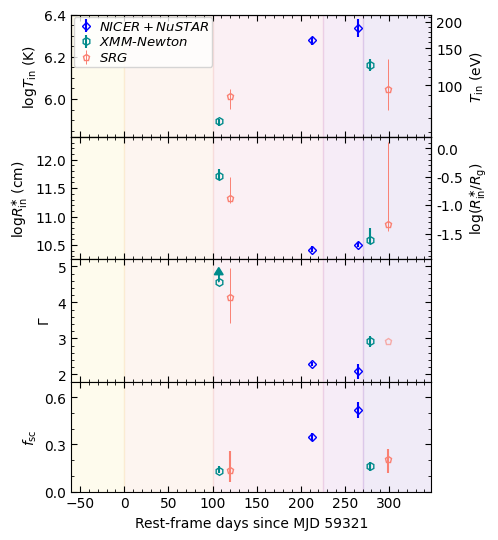

In [7]:
    fig = plt.figure(figsize = (4.8, 5.4))
    gs = fig.add_gridspec(4, 1, 
                          hspace=0.0, wspace = 0, 
                          height_ratios=[1,1, 1,0.9])
    axs = gs.subplots(sharex=True)
    add_xray_pars(axs)
    
    custom_myax2(axs)
    
    plt.tight_layout(rect = (-0.03, -0.01, 1.03, 1.01))